<a href="https://colab.research.google.com/github/nhuynguyenthi/DoAnCN2_NLP/blob/master/CNN_BILSTM_TV_TA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.



[link text](https://huggingface.co/datasets/uitnlp/vietnamese_students_feedback/viewer)




In [ ]:
from datasets import load_dataset

# Tải dataset
ds = load_dataset("uitnlp/vietnamese_students_feedback")

# Lưu từng tập dữ liệu xuống máy
ds['train'].to_csv("train.csv", index=False)
ds['validation'].to_csv("validation.csv", index=False)
ds['test'].to_csv("test.csv", index=False)

print("Tập train, validation, và test đã được lưu dưới dạng CSV.")


Creating CSV from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

Tập train, validation, và test đã được lưu dưới dạng CSV.


In [ ]:
data_vn = pd.read_csv("/content/train.csv")
data_vn.shape

(11426, 3)

In [ ]:
# Kiểm tra kiểu dữ liệu của các biến trong DataFrame
data_types = data_vn.dtypes
# Tạo danh sách để lưu biến phân loại và biến số
categorical_vars = []
numeric_vars = []
# Phân loại các biến dựa trên kiểu dữ liệu
for var, dtype in data_types.items():
    if dtype == 'object' or dtype.name == 'category':
        categorical_vars.append(var)
    elif dtype in ['int64', 'float64']:
        numeric_vars.append(var)

# In ra kết quả
print("Biến phân loại (Categorical Variables):")
print(categorical_vars)

print("\nBiến số (Numeric Variables):")
print(numeric_vars)


Biến phân loại (Categorical Variables):
['sentence']

Biến số (Numeric Variables):
['sentiment', 'topic']


In [ ]:
print(data_vn.columns)


Index(['sentence', 'sentiment', 'topic'], dtype='object')


In [ ]:
import re

# Giữ lại chỉ các cột cần thiết
data_vn = data_vn[['sentence', 'sentiment']].copy()  # Đảm bảo giữ đúng cột

# Tạo ánh xạ từ giá trị số sang nhãn tiếng Anh
sentiment_mapping = {0: 'tiêu cực', 1: 'trung lập', 2: 'tích cực'}
data_vn['sentiment'] = data_vn['sentiment'].map(sentiment_mapping)

# Đổi tên cột 'sentence' thành 'text'
data_vn = data_vn.rename(columns={'sentence': 'text'})

# Hàm làm sạch
def clean_text(text, lang='vi'):
    if isinstance(text, str):
        text = re.sub(r'[^\u00C0-\u1EF9a-zA-Z0-9\s]', '', text)
        text = text.lower()
        text = text.strip()
        return text
    return text

# Áp dụng hàm làm sạch
data_vn['text'] = data_vn['text'].apply(lambda x: clean_text(x, lang='vi'))

# Loại bỏ hàng trống
data_vn.dropna(inplace=True)

# Kiểm tra kết quả
print("Dữ liệu tiếng Việt sau xử lý:")
display(data_vn.head())


Dữ liệu tiếng Việt sau xử lý:


,text,sentiment
0,slide giáo trình đầy đủ,tích cực
1,nhiệt tình giảng dạy gần gũi với sinh viên,tích cực
2,đi học đầy đủ full điểm chuyên cần,tiêu cực
3,chưa áp dụng công nghệ thông tin và các thiết bị hỗ trợ cho việc giảng dạy,tiêu cực
4,thầy giảng bài hay có nhiều bài tập ví dụ ngay trên lớp,tích cực


In [ ]:
data_vn['sentiment'].unique()

array(['tích cực', 'tiêu cực', 'trung lập'], dtype=object)

In [ ]:
data_vn.isnull().sum()

,0
text,0
sentiment,0


In [ ]:
print(data_vn['sentiment'].value_counts())

sentiment
tích cực     5643
tiêu cực     5325
trung lập     458
Name: count, dtype: int64


In [ ]:
!pip install pyvi
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pyvi import ViTokenizer
from pyvi import ViUtils
import random

In [ ]:
import random
import pandas as pd
from pyvi import ViTokenizer

# Cập nhật từ điển từ đồng nghĩa
synonym_dict = {
    "nhiệt_tình": ["tận_tâm", "tận_tụy", "nhiệt_huyết"],
    "giảng_dạy": ["dạy_học", "truyền_đạt", "hướng_dẫn"],
    "dễ_hiểu": ["rõ_ràng", "dễ_tiếp_thụ", "dễ_nắm_bắt"],
    "sinh_viên": ["học_sinh", "người_học"],
    "tận_tâm": ["tận_tình", "chu_đáo", "hết_lòng"],
    "khó_hiểu": ["phức_tạp", "rắc_rối", "khó_tiếp_thụ"],
    "giải_thích": ["làm_rõ", "diễn_giải", "chỉ_dẫn"],
    "bài_giảng": ["giáo_trình", "nội_dung_dạy_học", "bài_học"],
    "truyền_đạt": ["giảng_giải", "phổ_biến", "truyền_tải"],
    "vui_vẻ": ["hài_hước", "thân_thiện", "hòa_đồng"],
    "giáo_viên": ["thầy_cô", "giảng_viên"],
    "thầy": ["giảng_viên_nam", "giáo_viên_nam"],
    "cô": ["giảng_viên_nữ", "giáo_viên_nữ"],
    "buổi_học": ["tiết_học", "giờ_học"],
    "bài_tập": ["nhiệm_vụ", "bài_thực_hành", "đề_tài"],
    "kiến_thức": ["tri_thức", "nhận_thức", "học_thuật"],
    "lớp_học": ["phòng_học", "các_buổi_học"],
    "hệ_thống": ["cấu_trúc", "hệ_biểu"],
    "phòng_học": ["lớp", "căn_hộp"],
    "nội_dung": ["chủ_đề", "tóm_lược"],
    "thầy_cô": ["giáo_viên", "giảng_viên"],
    "kỹ_năng": ["năng_lực", "kĩ_luật"],
    "thực_hành": ["luyện_tập", "giải_pháp"],
    "thời_gian": ["giờ_làm", "thời_lượng"],
    "lịch_học": ["bản_đồ_học", "kế_hoạch_học"],
    "giáo_trình": ["slide_bài_học", "tài_liệu_học"],
    "slide": ["giáo_trình_trình_bày", "bài_trình_bày"],
    "tài_liệu": ["văn_bản", "hồ_sơ", "tài_nguyên"],
    "đáp_án": ["giải_pháp", "câu_trả_lời", "phương_án"],
    "động_lực": ["nhiệt_huyết", "sự_kích_thích", "sự_cống_hiến"],
    "hứng_thú": ["sự_thú_vị", "sự_đam_mê", "sự_nhiệt_huyết"],
    "hoạt_động": ["sự_kiện", "công_việc", "chương_trình"],
    "phương_pháp": ["cách_thức", "chiến_lược", "tiếp_cận"],
    "sự_tương_tác": ["giao_tiếp", "tương_lại", "hợp_tác"],
    "bài_học": ["tiết_học", "nội_dung_học", "giáo_trình"],
    "giải_bài_tập": ["hỗ_trợ_bài_tập", "hướng_dẫn_bài_tập", "giải_pháp_bài_tập"],
    "khảo_sat": ["đánh_giá", "phản_hồi", "báo_cáo"],
    "truyền_cảm_hứng": ["khơi_giấy", "động_lực", "gây_hứng_thú"],
    "phát_triển": ["nâng_cao", "tăng_cường", "mở_rộng"],
    "tiến_độ": ["nhịp_độ", "tốc_độ", "sự_phát_triển"],
    "mục_tiêu": ["đích", "sứ_mệnh", "nhằm_đạt"],
    "tương_lai": ["tương_lại", "ngay_trước", "sắp_tới"],
    "cập_nhật": ["mới_hóa", "nâng_cao", "bổ_sung"],
    "quản_lý": ["sự_quản_trị", "điều_hành", "hành_chính"],
    "chất_lượng": ["độ_chất", "sự_tốt", "mức_độ"],
    "phản_hồi": ["đánh_giá", "bình_chọn", "phản_đối"],
    "hỗ_trợ": ["giúp_đỡ", "cung_cấp_sự_giúp", "hỗ_trợ"],
    "thông_báo": ["báo_cáo", "gửi_tin_nhắn", "truyền_tải"],
    "sắp_xếp": ["tổ_chức", "điều_hoàn", "bố_trí"],
    "khoá_học": ["chương_trình_học", "đợt_học", "lớp_học"],
    "tạo_không_khí": ["xây_dựng_môi_trường", "tạo_dựng_sự_hứng_thú", "xây_dựng_sự_thú_vị"],
    "công_cụ": ["dụng_cụ", "thiết_bị", "phụ_tùng"],
    "cách_truyền_dẫn": ["phương_pháp_truyền_dẫn", "cách_thức_truyền_dẫn", "phương_pháp_giao_tiếp"],
    "phong_cách": ["cách_thức", "thái_độ", "style"],
    "tiêu_đề": ["chủ_đề", "nội_dung", "đề_tài"],
    "học_viện": ["trường_học", "đại_học", "cơ_sở_giáo_dục"],
    "kỹ_chất": ["năng_khả", "khả_năng", "năng_lực"],
    "cung_cấp": ["cung_đưa", "phân_phối", "khoảng_cách"],
    "nghiêm_khắc": ["cứng_rắn", "khắt_khe", " nghiêm_trọng"],
    "quy_định": ["quy_tắc", "luật_pháp", "hướng_dẫn"],
    "tài_nguyên": ["nguồn_lực", "nguồn_hàng", "tài_lý"],
    "tương_lai": ["tương_lại", "ngay_trước", "sắp_tới"],
    "cải_thiện": ["nâng_cao", "tăng_cường", "mở_rộng"],
    "bảo_trì": ["sửa_chữa", "bảo_hành", "duy_trì"],
    "thiết_bị": ["dụng_cụ", "công_cụ", "máy_móc"],
    "tạo_dựng": ["xây_dựng", "phát_triển", "thiết_kế"],
    "tối_ưu": ["tối_thiểu", "cân_bằng", "hoàn_hảo"],
    "cấu_hình": ["cấu_trúc", "thiết_kế", "mô_hình"],
    "hỗ_trợ": ["giúp_đỡ", "cung_cấp_sự_giúp", "hỗ_trợ"],
    "đánh_giá": ["đo_lường", "kiểm_soát", "đánh_trị"],
    "phổ_biến": ["lan_tỏa", "truyền_bạt", "truyền_dạt"],
    "kế_hoạch": ["lộ_trình", "chương_trình", "bản_đồ"],
    "thúc_đẩy": ["đẩy_mạnh", "khuyến_khích", "động_lực"],
    "tiến_hành": ["đi_thẳng", "tiếp_tục", "phát_triển"],
    "sử_dụng": ["áp_dụng", "dùng", "hưởng_dụng"],
    "tăng_cường": ["nâng_cao", "củng_cố", "phát_triển"],
    "giải_pháp": ["cách_thức", "phương_an", "biện_pháp"],
    "sự_quản_lý": ["quản_trị", "điều_hành", "hành_chính"],
    "luyện_tập": ["thực_hành", "giải_pháp", "cải_thiện"],
    "mở_rộng": ["nâng_cao", "tăng_cường", "phát_triển"],
    "sự_kích_thích": ["động_lực", "hứng_thú", "nhiệt_huyết"],
    "sự_thú_vị": ["hứng_thú", "đam_mê", "nhiệt_huyết"],
    "học_thuật": ["nhận_thức", "tri_thức", "kiến_thức"],
    "công_việc": ["nhiệm_vụ", "hoạt_động", "sự_kiện"],
    "tích_cực": ["đáng_ngưỡng", "tốt_bạ̀n", "hữu_ích"],
    "độ_chất": ["chất_lượng", "sự_tốt", "mức_độ"],
    "cứng_rắn": ["nghiêm_khắc", "khắt_khe", "nhiệt_huyết"],
    "giải_pháp": ["cách_thức", "phương_an", "biện_pháp"],
    "sự_thú_vị": ["hứng_thú", "đam_mê", "nhiệt_huyết"],
    "cấu_trúc": ["hệ_thống", "cấu_hình", "thiết_kế"],
    "phối_hợp": ["hợp_tác", "cộng_tác", "làm_việc_cùng"],
    "xây_dựng": ["tạo_dựng", "phát_triển", "thiết_kế"],
    "chủ_tịch": ["đồng_tịch", "hội_đồng", "bầu_cử"],
    "tạo_cảm_hứng": ["khơi_giấy", "động_lực", "gây_hứng_thú"],
    "đề_kiến": ["bình_chọn", "phản_hồi", "đánh_giá"],
    "báo_cáo": ["thông_báo", "đánh_giá", "phản_hồi"],
    "sự_thích_nghi": ["thích_nghi", "sự_dễ_chấp_nhận", "tương_thích"],
    "phương_pháp_truyền_dẫn": ["cách_thức_truyền_dẫn", "phương_pháp_giao_tiếp", "cách_truyền_dẫn"],
    "truyền_thông": ["giao_tiếp", "lan_tỏa", "phổ_biến"],
    "bài_thực_hành": ["thực_hành", "luyện_tập", "giải_pháp"],
    "nâng_cao": ["tăng_cường", "phát_triển", "cải_thiện"],
    "học_tập": ["học_hỏi", "học_thiếu", "học_hụ"],
    "cải_cách": ["nâng_cao", "cải_thiện", "phát_triển"],
    "môi_trường": ["không_gian", "vùng_quanh", "cơ_sở"],
    "tích_hợp": ["kết_hợp", "gắn_kết", "hợp_lý"],
    "tương_tác": ["giao_tiếp", "hợp_tác", "liên_kết"],
    "cập_nhật": ["mới_hóa", "nâng_cao", "bổ_sung"],
    "đổi_mới": ["tạo_dựng", "phát_triển", "cải_thiện"],
    "hướng_dẫn": ["truyền_dẫn", "giải_pháp", "cung_cấp_sự_hướng_dẫn"],
    "sự_khó_hiểu": ["phức_tạp", "rắc_rối", "khó_tiếp_thụ"],
    "thể_lệ": ["quy_tắc", "luật_pháp", "hướng_dẫn"],
    "mục_tiêu_học_tập": ["đích_học_tập", "sứ_mệnh_học_tập", "mục_dích_học_tập"],
    "giảng_dạy": ["dạy_học", "truyền_đạt", "hướng_dẫn"],
    "truyền_thông": ["giao_tiếp", "lan_tỏa", "phổ_biến"],
    "phát_triển": ["nâng_cao", "tăng_cường", "mở_rộng"],
    "đào_tạo": ["học_hỏi", "giảng_dạy", "huấn_luyện"],
    "thực_tế": ["thực_sự", "thực_phẩm", "thực_động"],
    "học_sinh": ["sinh_viên", "người_học", "học_viên"],
    "cống_hiến": ["nhiệt_huyết", "tận_tâm", "tận_trọng"],
    "phổ_biến": ["lan_tỏa", "truyền_tải", "giảng_bày"],
    "lộ_trình": ["kế_hoạch", "chương_trình", "bản_đồ"],
    "hướng_dẫn_chi_tiết": ["giải_pháp_chi_tiết", "truyền_dẫn_chi_tiết", "hướng_dẫn_rõ_ràng"],
    "giải_bài_tập": ["hỗ_trợ_bài_tập", "hướng_dẫn_bài_tập", "giải_pháp_bài_tập"],
    "công_ty": ["doanh_nghiệp", "cơ_sở_nghề_nghiệp", "thương_mại"],
    "khả_năng": ["năng_lực", "kỹ_năng", "năng_khả"],
    "môi_trường_học_tập": ["không_gian_học_tập", "cơ_sở_học_tập", "môi_trường_giao_tiếp"],
    "học_bổng": ["giúp_đỡ_tài_chính", "hỗ_trợ_tài_chính", "quỹ_học_tập"],
    "bài_thi": ["đề_thi", "kiểm_trắc", "đánh_giá"],
    "điểm_số": ["số_buổi", "điểm_lần", "điểm_thi"],
    "sự_phát_triển": ["sự_nâng_cao", "sự_tăng_cường", "sự_mở_rộng"],
    "tương_lai_sinh_viên": ["tương_lai_người_học", "tương_lai_học_sinh", "tương_lại_sinh_viên"],
    "đánh_giá": ["đo_lường", "kiểm_soát", "đánh_trị"],
    "phổ_biến": ["lan_tỏa", "truyền_tải", "truyền_dạt"],
    "kế_hoạch_học_tập": ["bản_đồ_học", "lộ_trình_học", "kế_hoạch_học"],
    "tài_liệu_học_tập": ["slide_bài_học", "giáo_trình", "văn_bản_học_tập"],
    "kỹ_năng_giao_tiếp": ["năng_khả_giao_tiếp", "kỹ_năng_truyền_dẫn", "kỹ_năng_liên_kết"],
    "học_thêm": ["học_bổ_sung", "học_bổ_trợ", "học_tăng_cường"],
    "công_cụ_học_tập": ["dụng_cụ_học_tập", "thiết_bị_học_tập", "phụ_tùng_học_tập"],
    "giáo_trình_trực_tuyến": ["slide_bài_học", "tài_liệu_trực_tuyến", "giáo_trình_online"],
    "công_nghệ": ["kỹ_thuật", "công_cụ", "phương_pháp"],
    "trình_bày": ["bày_tỏ", "trình_bày", "giới_thiệu"],
    "phối_hợp": ["hợp_tác", "liên_kết", "đồng_hành"],
    "sự_tương_tác": ["giao_tiếp", "hợp_tác", "liên_kết"],
    "công_nghệ_mới": ["công_nghệ_mới_lạ", "công_nghệ_hồi_giang", "công_nghệ_thiên_tiên"],
    "học_viện": ["trường_học", "đại_học", "cơ_sở_giáo_dục"],
    "khoa_học": ["sư_phạm", "công_nghệ", "nghệ_thuật"],
    "sự_tham_gia": ["tham_gia", "hợp_tác", "tham_mạng"],
    "nhiệm_vụ": ["bài_tập", "công_việc", "đề_thi"],
    "mô_hình": ["hệ_thống", "cấu_trúc", "thiết_kế"],
    "hỗ_trợ_sinh_viên": ["giúp_đỡ_sinh_viên", "hỗ_trợ_học_tập", "hỗ_trợ_truyền_dẫn"],
    "cập_nhật_giáo_trình": ["mới_hóa_giáo_trình", "nâng_cao_giáo_trình", "bổ_sung_giáo_trình"],
    "giảng_viên": ["giáo_viên", "thầy_cô", "giảng_dạy"],
    "hướng_dẫn_thực_hành": ["hướng_dẫn_luyện_tập", "hướng_dẫn_bài_thực_hành", "hướng_dẫn_thực_tế"],
    "sự_nhiệt_huyết": ["sự_nhiệt_tình", "sự_dedication", "sự_tận_tâm"],
    "truyền_dẫn_kiến_thức": ["giảng_giải_kiến_thức", "truyền_thông_kiến_thức", "hướng_dẫn_kiến_thức"],
    "học_hỏi": ["học_tập", "tìm_hiểu", "nâng_cao"],
    "phát_triển_bản_thân": ["nâng_cao_bản_thân", "cải_thiện_bản_thân", "phát_huy_bản_thân"],
    "sự_phát_triển": ["sự_nâng_cao", "sự_tăng_cường", "sự_mở_rộng"],
    "bài_tập_vận_dụng": ["bài_tập_áp_dụng", "bài_tập_thực_hành", "bài_tập_liên_kết"],
    "giải_pháp_bài_tập": ["hướng_dẫn_bài_tập", "giải_bài_tập", "cách_thức_bài_tập"],
    "cơ_sở_học_tập": ["môi_trường_học_tập", "phòng_học", "lớp_học"],
    "đào_tạo_sinh_viên": ["huấn_luyện_sinh_viên", "hướng_dẫn_sinh_viên", "giảng_dạy_sinh_viên"],
    "tăng_cường_kỹ_năng": ["nâng_cao_kỹ_năng", "phát_triển_kỹ_năng", "củng_cố_kỹ_năng"],
    "sự_tham_gia": ["tham_gia", "hợp_tác", "tham_mạng"],
    "công_cụ_mới": ["công_cụ_hồi_giang", "công_cụ_thiên_tiên", "công_cụ_mới_lạ"],
    "học_viên": ["sinh_viên", "học_sinh", "người_học"],
    "sự_kết_hợp": ["hợp_tác", "liên_kết", "phối_hợp"],
    "tài_nguyên_học_tập": ["tài_liệu_học_tập", "văn_bản_học_tập", "slide_bài_học"],
    "sự_áp_dụng": ["công_dụng", "sự_dùng", "sự_hưởng_dụng"],
    "sự_hướng_dẫn": ["hướng_dẫn", "truyền_dẫn", "giải_pháp"],
    "sự_phát_triển": ["phát_triển", "nâng_cao", "tăng_cường"],
    "nâng_cao_kỹ_năng": ["tăng_cường_kỹ_năng", "phát_triển_kỹ_năng", "củng_cố_kỹ_năng"],
    "giải_pháp_thực_tế": ["phương_an_thực_tế", "cách_thức_thực_tế", "hướng_dẫn_thực_tế"],
    "sự_quản_lý": ["quản_trị", "điều_hành", "hành_chính"],
    "sự_cải_thiện": ["nâng_cao", "tăng_cường", "mở_rộng"],
    "giáo_trình_dạy_học": ["slide_bài_học", "tài_liệu_học", "bài_học"],
    "truyền_thông_kỹ_năng": ["giáo_trình_truyền_thông", "hướng_dẫn_giao_tiếp", "phương_pháp_truyền_dẫn"],
    "phát_triển_kỹ_năng": ["nâng_cao_kỹ_năng", "tăng_cường_kỹ_năng", "củng_cố_kỹ_năng"],
    "học_tập_thực_hành": ["thực_hành_học_tập", "luyện_tập_học_tập", "giải_pháp_học_tập"],
    "sự_hướng_dẫn_thực_hành": ["hướng_dẫn_luyện_tập", "hướng_dẫn_bài_thực_hành", "hướng_dẫn_thực_tế"],
    "học_thêm_kỹ_năng": ["học_bổ_sung_kỹ_năng", "học_bổ_trợ_kỹ_năng", "học_tăng_cường_kỹ_năng"],
    "truyền_dẫn_sự_đam_mê": ["giảng_giải_sự_đam_mê", "truyền_thông_sự_đam_mê", "hướng_dẫn_sự_đam_mê"],
    "học_tập_phát_triển": ["học_hỏi_phát_triển", "học_thiếu_phát_triển", "học_tăng_cường_phát_triển"],
    "học_sinh_năng_lực": ["sinh_viên_năng_lực", "học_viên_năng_lực", "người_học_năng_lực"],
    "truyền_dẫn_thực_hành": ["giảng_giải_thực_hành", "truyền_thông_thực_hành", "hướng_dẫn_thực_hành"],
    "hỗ_trợ_truyền_dẫn": ["hỗ_trợ_giảng_giải", "hỗ_trợ_truyền_thông", "hỗ_trợ_truyền_tải"],
    "kỹ_năng_giao_tiếp": ["năng_khả_giao_tiếp", "kỹ_năng_truyền_dẫn", "kỹ_năng_liên_kết"],
    "sự_phát_triển_bản_thân": ["phát_triển_bản_thân", "nâng_cao_bản_thân", "cải_thiện_bản_thân"],
    "sự_khó_hiểu": ["khó_hai_bắt", "phức_tạp", "rắc_rối"],
    "sự_tương_tác_giao_tiếp": ["tương_lai_giao_tiếp", "giao_tiếp_hợp_tác", "liên_kết_giao_tiếp"],
    "hướng_dẫn_phát_triển": ["hướng_dẫn_nâng_cao", "hướng_dẫn_tăng_cường", "hướng_dẫn_mở_rộng"],
    "sự_nhiệt_huyết": ["sự_nhiệt_tình", "sự_dedication", "sự_tận_tâm"],
    "truyền_dẫn_giáo_trình": ["giảng_giải_giáo_trình", "truyền_thông_giáo_trình", "hướng_dẫn_giáo_trình"],
    "cải_thiện_sự_quản_lý": ["nâng_cao_sự_quản_lý", "tăng_cường_sự_quản_lý", "mở_rộng_sự_quản_lý"],
    "học_tập_nâng_cao": ["học_hỏi_nâng_cao", "học_thiếu_nâng_cao", "học_tăng_cường_nâng_cao"],
    "truyền_dẫn_kiến_thức": ["giảng_giải_kiến_thức", "truyền_thông_kiến_thức", "hướng_dẫn_kiến_thức"],
    "học_hỏi_phát_triển": ["học_tập_phát_triển", "học_thiếu_phát_triển", "học_tăng_cường_phát_triển"],
    "sự_hướng_dẫn_phát_triển": ["hướng_dẫn_nâng_cao_phát_triển", "hướng_dẫn_tăng_cường_phát_triển", "hướng_dẫn_mở_rộng_phát_triển"],
    "học_tập_tăng_cường": ["học_hỏi_tăng_cường", "học_thiếu_tăng_cường", "học_tăng_cường_nâng_cao"],
    "sự_phát_triển_kỹ_năng": ["phát_triển_kỹ_năng", "nâng_cao_kỹ_năng", "tăng_cường_kỹ_năng"],
    "học_thêm_phát_triển": ["học_bổ_sung_phát_triển", "học_bổ_trợ_phát_triển", "học_tăng_cường_phát_triển"],
    "học_tập_giao_tiếp": ["học_hỏi_giao_tiếp", "học_thiếu_giao_tiếp", "học_tăng_cường_giao_tiếp"],
    "sự_truyền_dẫn_giao_tiếp": ["sự_truyền_thông_giao_tiếp", "sự_giảng_giải_giao_tiếp", "sự_hướng_dẫn_giao_tiếp"],
    "truyền_dẫn_phát_triển": ["giảng_giải_phát_triển", "truyền_thông_phát_triển", "hướng_dẫn_phát_triển"],
    "hỗ_trợ_học_tập": ["hỗ_trợ_học_hỏi", "hỗ_trợ_học_thiếu", "hỗ_trợ_học_tăng_cường"],
    "học_hỏi_truyền_dẫn": ["học_tập_truyền_dẫn", "học_thiếu_truyền_dẫn", "học_tăng_cường_truyền_dẫn"],
    "sự_hướng_dẫn_học_tập": ["sự_hướng_dẫn_học_hỏi", "sự_hướng_dẫn_học_thiếu", "sự_hướng_dẫn_học_tăng_cường"],
    "hỗ_trợ_truyền_dẫn_kiến_thức": ["hỗ_trợ_giảng_giải_kiến_thức", "hỗ_trợ_truyền_thông_kiến_thức", "hỗ_trợ_hướng_dẫn_kiến_thức"],
    "sự_nâng_cao_kỹ_năng": ["sự_tăng_cường_kỹ_năng", "sự_phát_triển_kỹ_năng", "sự_củng_cố_kỹ_năng"],
    "hỗ_trợ_kỹ_năng": ["hỗ_trợ_năng_lực", "hỗ_trợ_kĩ_luật", "hỗ_trợ_kỹ_thuật"],
    "truyền_dẫn_kỹ_năng": ["giảng_giải_kỹ_năng", "truyền_thông_kỹ_năng", "hướng_dẫn_kỹ_năng"],
    "hướng_dẫn_kỹ_năng": ["truyền_dẫn_kỹ_năng", "giảng_giải_kỹ_năng", "hỗ_trợ_kỹ_năng"],
    "nâng_cao_kiến_thức": ["tăng_cường_kiến_thức", "phát_triển_kiến_thức", "củng_cố_kiến_thức"],
    "phát_triển_năng_lực": ["nâng_cao_năng_lực", "tăng_cường_năng_lực", "củng_cố_năng_lực"],
    "học_tập_nâng_cao": ["học_hỏi_nâng_cao", "học_thiếu_nâng_cao", "học_tăng_cường_nâng_cao"],
    "truyền_dẫn_năng_lực": ["giảng_giải_năng_lực", "truyền_thông_năng_lực", "hướng_dẫn_năng_lực"],
    "hướng_dẫn_phát_triển_kỹ_năng": ["hướng_dẫn_nâng_cao_kỹ_năng", "hướng_dẫn_tăng_cường_kỹ_năng", "hướng_dẫn_củng_cố_kỹ_năng"],
    "hỗ_trợ_phát_triển": ["hỗ_trợ_nâng_cao", "hỗ_trợ_tăng_cường", "hỗ_trợ_mở_rộng"],
    "hướng_dẫn_phát_triển_bản_thân": ["hướng_dẫn_nâng_cao_bản_thân", "hướng_dẫn_tăng_cường_bản_thân", "hướng_dẫn_củng_cố_bản_thân"],
    "truyền_dẫn_kỹ_năng_giao_tiếp": ["giảng_giải_kỹ_năng_giao_tiếp", "truyền_thông_kỹ_năng_giao_tiếp", "hướng_dẫn_kỹ_năng_giao_tiếp"],
    "học_tập_hướng_dẫn": ["học_hỏi_hướng_dẫn", "học_thiếu_hướng_dẫn", "học_tăng_cường_hướng_dẫn"],
    "hỗ_trợ_giảng_dạy": ["hỗ_trợ_truyền_dẫn", "hỗ_trợ_truyền_thông", "hỗ_trợ_hướng_dẫn"],
    "truyền_dẫn_phát_triển_kỹ_năng": ["giảng_giải_phát_triển_kỹ_năng", "truyền_thông_phát_triển_kỹ_năng", "hướng_dẫn_phát_triển_kỹ_năng"],
    "hỗ_trợ_phát_triển_kỹ_năng": ["hỗ_trợ_nâng_cao_kỹ_năng", "hỗ_trợ_tăng_cường_kỹ_năng", "hỗ_trợ_củng_cố_kỹ_năng"],
    "truyền_dẫn_sự_nhiệt_huyết": ["giảng_giải_sự_nhiệt_huyết", "truyền_thông_sự_nhiệt_huyết", "hướng_dẫn_sự_nhiệt_huyết"],
    "hỗ_trợ_sự_nhiệt_huyết": ["hỗ_trợ_sự_nhiệt_tình", "hỗ_trợ_sự_nhiệt_huyết", "hỗ_trợ_sự_tận_tâm"],
    "học_tập_truyền_dẫn": ["học_hỏi_truyền_dẫn", "học_thiếu_truyền_dẫn", "học_tăng_cường_truyền_dẫn"],
    "truyền_dẫn_học_tập": ["giảng_giải_học_tập", "truyền_thông_học_tập", "hướng_dẫn_học_tập"],
    "hướng_dẫn_truyền_dẫn": ["hướng_dẫn_truyền_thông", "hướng_dẫn_giảng_giải", "hướng_dẫn_truyền_tải"],
    "học_tập_hướng_dẫn_phát_triển": ["học_hỏi_hướng_dẫn_phát_triển", "học_thiếu_hướng_dẫn_phát_triển", "học_tăng_cường_hướng_dẫn_phát_triển"],
    "sự_phát_triển_năng_lực": ["sự_nâng_cao_năng_lực", "sự_tăng_cường_năng_lực", "sự_củng_cố_năng_lực"],
    "sự_truyền_dẫn_kiến_thức": ["sự_giảng_giải_kiến_thức", "sự_truyền_thông_kiến_thức", "sự_hướng_dẫn_kiến_thức"],
    "hướng_dẫn_sự_phát_triển": ["hướng_dẫn_sự_nâng_cao", "hướng_dẫn_sự_tăng_cường", "hướng_dẫn_sự_mở_rộng"],
    "hỗ_trợ_truyền_dẫn_phát_triển": ["hỗ_trợ_truyền_dẫn_phát_triển", "hỗ_trợ_truyền_thông_phát_triển", "hỗ_trợ_giảng_giải_phát_triển"],
    "sự_hướng_dẫn_phát_triển_năng_lực": ["sự_hướng_dẫn_phát_triển_nâng_cao", "sự_hướng_dẫn_phát_triển_tăng_cường", "sự_hướng_dẫn_phát_triển_củng_cố"],
    "truyền_dẫn_truyền_thông": ["giảng_giải_truyền_thông", "truyền_thông_truyền_dẫn", "hướng_dẫn_truyền_thông"],
    "hướng_dẫn_truyền_dẫn_kiến_thức": ["hướng_dẫn_truyền_thông_kiến_thức", "hướng_dẫn_giảng_giải_kiến_thức", "hướng_dẫn_truyền_tải_kiến_thức"],
    "hỗ_trợ_hướng_dẫn": ["hỗ_trợ_truyền_dẫn", "hỗ_trợ_truyền_thông", "hỗ_trợ_giảng_giải"],
    "hướng_dẫn_phát_triển_kỹ_năng_giao_tiếp": ["hướng_dẫn_phát_triển_kỹ_năng_giao_tiếp", "hướng_dẫn_phát_triển_kỹ_năng_truyền_dẫn", "hướng_dẫn_phát_triển_kỹ_năng_liên_kết"],
    "hỗ_trợ_phát_triển_kỹ_năng_giao_tiếp": ["hỗ_trợ_phát_triển_kỹ_năng_giao_tiếp", "hỗ_trợ_phát_triển_kỹ_năng_truyền_dẫn", "hỗ_trợ_phát_triển_kỹ_năng_liên_kết"],
    "sự_hướng_dẫn_phát_triển_kỹ_năng_giao_tiếp": ["sự_hướng_dẫn_phát_triển_kỹ_năng_giao_tiếp", "sự_hướng_dẫn_phát_triển_kỹ_năng_truyền_dẫn", "sự_hướng_dẫn_phát_triển_kỹ_năng_liên_kết"],
    "truyền_dẫn_sự_phát_triển_kỹ_năng_giao_tiếp": ["truyền_dẫn_sự_phát_triển_kỹ_năng_giao_tiếp", "truyền_thông_sự_phát_triển_kỹ_năng_giao_tiếp", "giảng_giải_sự_phát_triển_kỹ_năng_giao_tiếp"],
}

In [ ]:
# Hàm thay thế từ đồng nghĩa
def replace_with_synonym(sentence, existing_sentences):
    words = sentence.split()  # Chia câu thành các từ
    new_words = []  # Danh sách chứa các từ mới thay thế
    for word in words:
        if word in synonym_dict and random.random() < 0.3:  # Thay thế với xác suất 30%
            new_word = random.choice(synonym_dict[word])  # Chọn từ đồng nghĩa ngẫu nhiên
            new_words.append(new_word)
        else:
            new_words.append(word)
    new_sentence = " ".join(new_words)  # Ghép các từ lại thành câu mới

    # Kiểm tra xem câu mới có trùng lặp không trong tập các câu đã có
    if new_sentence not in existing_sentences:
        existing_sentences.add(new_sentence)  # Thêm câu mới vào tập hợp
        return new_sentence
    return None  # Trả về None nếu câu mới trùng lặp

# Hàm thay đổi cấu trúc câu
def change_structure(sentence, existing_sentences):
    words = sentence.split()  # Chia câu thành các từ
    if len(words) > 5:
        middle_index = len(words) // 2  # Tính chỉ số giữa câu
        new_sentence = " ".join(words[middle_index:] + words[:middle_index])  # Đổi cấu trúc câu

        # Kiểm tra xem câu mới có trùng lặp không
        if new_sentence not in existing_sentences:
            existing_sentences.add(new_sentence)  # Thêm câu mới vào tập hợp
            return new_sentence
    return None  # Trả về None nếu câu mới trùng lặp hoặc không thay đổi được

# Hàm tạo câu mới bằng cách ghép nối
def combine_sentences(sentence1, sentence2, existing_sentences):
    new_sentence = f"{sentence1} và {sentence2}"  # Ghép hai câu thành một câu mới

    # Kiểm tra xem câu mới có trùng lặp không
    if new_sentence not in existing_sentences:
        existing_sentences.add(new_sentence)  # Thêm câu mới vào tập hợp
        return new_sentence
    return None  # Trả về None nếu câu mới trùng lặp

# Hàm tăng cường dữ liệu chính
def augment_data(sentence, additional_sentence, existing_sentences):
    augmented_sentences = []  # Danh sách chứa các câu tăng cường

    # Tạo 2 câu thay thế từ đồng nghĩa
    for _ in range(2):
        new_sentence = replace_with_synonym(sentence, existing_sentences)
        if new_sentence:
            augmented_sentences.append(new_sentence)

    # Tạo 1 câu thay đổi cấu trúc
    new_structure_sentence = change_structure(sentence, existing_sentences)
    if new_structure_sentence:
        augmented_sentences.append(new_structure_sentence)

    # Tạo câu ghép nối nếu có câu bổ sung
    if additional_sentence:
        combined_sentence = combine_sentences(sentence, additional_sentence, existing_sentences)
        if combined_sentence:
            augmented_sentences.append(combined_sentence)

    return augmented_sentences  # Trả về danh sách các câu tăng cường

In [ ]:
# Đầu vào
input_data = data_vn['text'].values  # Lấy dữ liệu văn bản
input_label = data_vn['sentiment'].values  # Lấy nhãn cảm xúc

# Danh sách để lưu câu và nhãn
input_pre = []  # Danh sách chứa câu đã qua xử lý
label_with_accent = []  # Danh sách chứa nhãn với dấu

# Tập hợp để lưu các câu đã được tạo
existing_sentences = set()  # Sử dụng set để đảm bảo không có câu trùng lặp

# Xử lý câu gốc và tạo câu tăng cường
for idx, dt in enumerate(input_data):
    # Xử lý câu gốc
    input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(dt))  # Chuyển câu thành danh sách từ
    input_text_pre = " ".join(input_text_pre)  # Ghép lại thành câu
    input_text_pre_no_accent = ViUtils.remove_accents(input_text_pre).decode("utf-8")  # Loại bỏ dấu
    input_text_pre_accent = ViTokenizer.tokenize(input_text_pre)  # Tách từ có dấu
    input_text_pre_no_accent = ViTokenizer.tokenize(input_text_pre_no_accent)  # Tách từ không dấu

    # Lưu câu gốc và nhãn tương ứng chỉ một lần
    if input_text_pre_accent not in existing_sentences:
        input_pre.append(input_text_pre_accent)
        label_with_accent.append(input_label[idx])
        existing_sentences.add(input_text_pre_accent)  # Thêm câu vào tập hợp để kiểm tra trùng lặp

    if input_text_pre_no_accent not in existing_sentences:
        input_pre.append(input_text_pre_no_accent)
        label_with_accent.append(input_label[idx])
        existing_sentences.add(input_text_pre_no_accent)

    # Tạo câu tăng cường cho cả hai câu (có dấu và không dấu)
    augmented_sentences_accent = augment_data(input_text_pre_accent, None, existing_sentences)
    augmented_sentences_no_accent = augment_data(input_text_pre_no_accent, None, existing_sentences)

    # Lưu các câu tăng cường (có dấu)
    for aug_sentence in augmented_sentences_accent:
        input_pre.append(aug_sentence)
        label_with_accent.append(input_label[idx])

    # Lưu các câu tăng cường (không dấu)
    for aug_sentence in augmented_sentences_no_accent:
        input_pre.append(aug_sentence)
        label_with_accent.append(input_label[idx])

# Tính tổng số câu ban đầu (trước khi tăng cường)
original_sentence_count = len(input_data) * 2  # Tổng số câu ban đầu (có dấu và không dấu)

# Tính tổng số câu sau khi tăng cường
augmented_sentence_count = len(input_pre) - original_sentence_count  # câu trong input_pre trừ đi câu gốc

# In ra kết quả
print(f"Tổng số câu ban đầu: {original_sentence_count}")
print(f"Số câu sau khi tăng cường: {augmented_sentence_count}")
print(f"Tổng số câu sau khi gộp lại: {len(input_pre)}")

# Kết hợp cả câu gốc và câu tăng cường
df_vietnames_combined = pd.DataFrame({'text': input_pre, 'sentiment': label_with_accent})
pd.set_option('display.max_colwidth', None)  # Hiển thị toàn bộ chiều dài cột
# In ra một số câu mẫu để kiểm tra
print(df_vietnames_combined.head(5))
print(f"Tổng số câu trong df_vietnames_combined: {len(df_vietnames_combined)}")


Tổng số câu ban đầu: 22852
Số câu sau khi tăng cường: 26374
Tổng số câu sau khi gộp lại: 49226
                                          text sentiment
0                      slide giáo_trình đầy_đủ  tích cực
1                      slide giao trinh day du  tích cực
2   nhiệt_tình giảng_dạy gần_gũi với sinh_viên  tích cực
3   nhiet tinh_giang day gan gui voi sinh vien  tích cực
4  nhiệt_huyết giảng_dạy gần_gũi với sinh_viên  tích cực
Tổng số câu trong df_vietnames_combined: 49226


In [ ]:
# Đếm số lượng các nhãn cảm xúc
label_counts = df_vietnames_combined['sentiment'].value_counts()

# In số lượng từng nhãn cảm xúc
print("Số lượng nhãn cảm xúc:")
print(f"Tích cực: {label_counts.get('tích cực', 0)}")
print(f"Trung lập: {label_counts.get('trung lập', 0)}")
print(f"Tiêu cực: {label_counts.get('tiêu cực', 0)}")

Số lượng nhãn cảm xúc:
Tích cực: 24078
Trung lập: 1572
Tiêu cực: 23576


In [ ]:
import pandas as pd

# Bước 1: Lọc dữ liệu theo các nhãn cảm xúc
negative_data = df_vietnames_combined[df_vietnames_combined['sentiment'] == 'tiêu cực']
neutral_data = df_vietnames_combined[df_vietnames_combined['sentiment'] == 'trung lập']
positive_data = df_vietnames_combined[df_vietnames_combined['sentiment'] == 'tích cực']

# Bước 2: Xác định số lượng mẫu cần thêm
negative_count = len(negative_data)
neutral_count = len(neutral_data)
positive_count = len(positive_data)

# Tìm nhãn có số lượng ít nhất (có thể chọn nhãn khác nhau)
max_count = max(negative_count, neutral_count, positive_count)

# Tính số lượng mẫu cần thêm cho mỗi nhãn
needed_negative_samples = max(0, max_count - negative_count)  # Chỉ cần oversample nếu số lượng thiếu
needed_neutral_samples = max(0, max_count - neutral_count)
needed_positive_samples = max(0, max_count - positive_count)

# Bước 3: Thực hiện oversampling cho từng nhãn để cân bằng (chỉ thực hiện nếu cần)
oversampled_negative = negative_data.sample(n=needed_negative_samples, replace=True, random_state=42) if needed_negative_samples > 0 else pd.DataFrame()
oversampled_neutral = neutral_data.sample(n=needed_neutral_samples, replace=True, random_state=42) if needed_neutral_samples > 0 else pd.DataFrame()
oversampled_positive = positive_data.sample(n=needed_positive_samples, replace=True, random_state=42) if needed_positive_samples > 0 else pd.DataFrame()

# Bước 4: Kết hợp dữ liệu ban đầu với các câu đã oversampling
balanced_data_vn = pd.concat([negative_data, neutral_data, positive_data, oversampled_negative, oversampled_neutral, oversampled_positive], ignore_index=True)

# Bước 5: Kiểm tra lại phân phối của các nhãn cảm xúc sau khi oversampling
balanced_label_counts = balanced_data_vn['sentiment'].value_counts()
print("Số lượng nhãn sau khi oversampling:")
print(balanced_label_counts)


Số lượng nhãn sau khi oversampling:
sentiment
tiêu cực     24078
trung lập    24078
tích cực     24078
Name: count, dtype: int64


In [ ]:
# Cộng tổng số câu cho cả ba nhãn
total_sentences = balanced_data_vn.shape[0]

print(f'Tổng số câu sau khi oversampling: {total_sentences}')


Tổng số câu sau khi oversampling: 72234


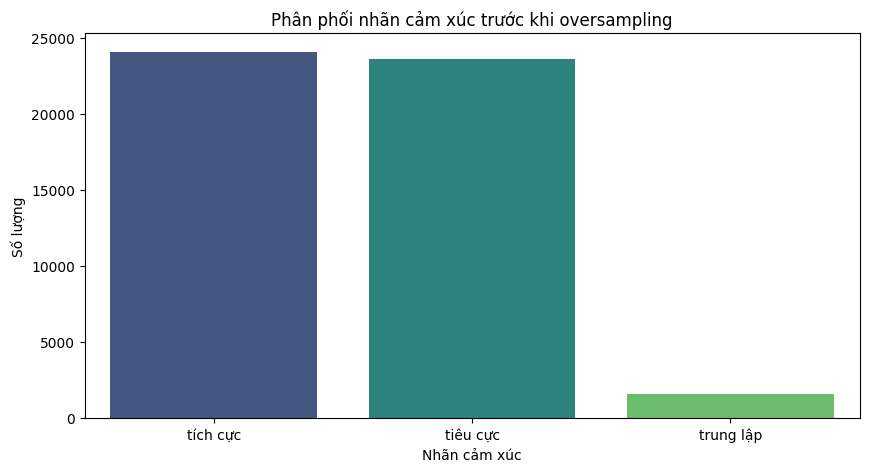

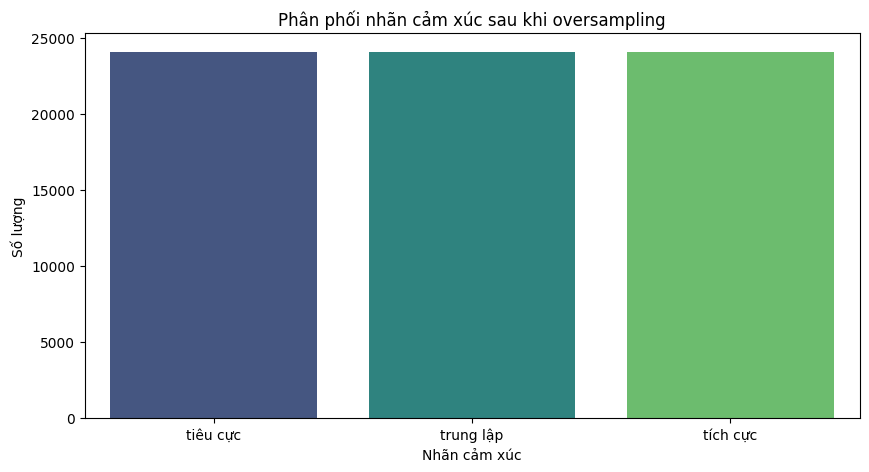

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Biểu đồ trước khi oversampling
plt.figure(figsize=(10, 5))
sns.countplot(data=df_vietnames_combined, x='sentiment', hue='sentiment', palette='viridis')
plt.title("Phân phối nhãn cảm xúc trước khi oversampling")
plt.xlabel("Nhãn cảm xúc")
plt.ylabel("Số lượng")
plt.show()

# Biểu đồ sau khi oversampling
plt.figure(figsize=(10, 5))
sns.countplot(data=balanced_data_vn, x='sentiment', hue='sentiment', palette='viridis')
plt.title("Phân phối nhãn cảm xúc sau khi oversampling")
plt.xlabel("Nhãn cảm xúc")
plt.ylabel("Số lượng")
plt.show()


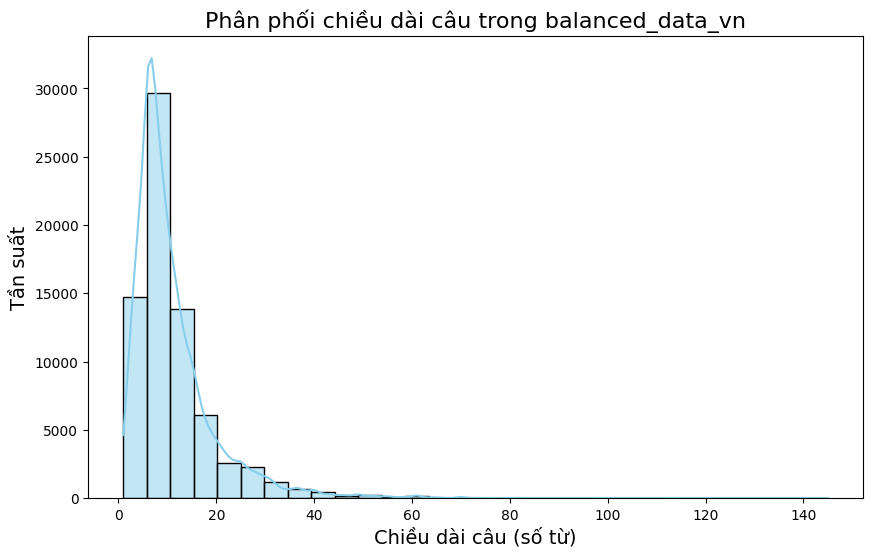

Maxlen (chiều dài câu lớn nhất): 145


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bước 1: Tính chiều dài của các câu trong balanced_data
sentence_lengths = balanced_data_vn['text'].apply(lambda x: len(x.split()))  # Tính số từ trong mỗi câu

# Bước 2: Vẽ biểu đồ phân phối chiều dài câu
plt.figure(figsize=(10, 6))
sns.histplot(sentence_lengths, kde=True, color='skyblue', bins=30)
plt.title("Phân phối chiều dài câu trong balanced_data_vn", fontsize=16)
plt.xlabel("Chiều dài câu (số từ)", fontsize=14)
plt.ylabel("Tần suất", fontsize=14)
plt.show()

# Bước 3: Tìm maxlen
maxlen = sentence_lengths.max()
print("Maxlen (chiều dài câu lớn nhất):", maxlen)


Tiếng anh

In [ ]:
import pandas as pd

In [ ]:
# Đọc dữ liệu tiếng Anh
english_data = pd.read_csv("/content/Restaurants_Train_v2.csv")
english_data.shape

(3693, 6)

In [ ]:
english_data.head()


,id,Sentence,Aspect Term,polarity,from,to
0,3121,But the staff was so horrible to us.,staff,negative,8,13
1,2777,"To be completely fair, the only redeeming fact...",food,positive,57,61
2,1634,"The food is uniformly exceptional, with a very...",food,positive,4,8
3,1634,"The food is uniformly exceptional, with a very...",kitchen,positive,55,62
4,1634,"The food is uniformly exceptional, with a very...",menu,neutral,141,145


In [ ]:
print(english_data['polarity'].value_counts())

polarity
positive    2164
negative     805
neutral      633
conflict      91
Name: count, dtype: int64


In [ ]:
english_data.isnull().sum()

,0
id,0
Sentence,0
Aspect Term,0
polarity,0
from,0
to,0


In [ ]:
# Giữ lại các hàng không có nhãn 'conflict' trong cột 'polarity'
english_data = english_data[english_data['polarity'] != 'conflict']

# Kiểm tra lại phân phối nhãn sau khi xóa
print(english_data['polarity'].value_counts())


polarity
positive    2164
negative     805
neutral      633
Name: count, dtype: int64


In [ ]:
english_data.shape

(3602, 6)

In [ ]:
import re

# Giữ lại các cột quan trọng
english_data = english_data[['Sentence', 'polarity']]

# Đổi tên các cột cho thống nhất
english_data.columns = ['text', 'sentiment']

# Chuyển đổi nhãn cảm xúc về chữ thường
english_data.loc[:, 'sentiment'] = english_data['sentiment'].str.lower()

# Xử lý lỗi mã hóa: thay thế các ký tự lỗi phổ biến
english_data.loc[:, 'text'] = english_data['text'].replace({
    "â€™": "'",
    "â€": "\"",
    "â€œ": "\"",
    "â€˜": "'",
    "â€“": "-"
}, regex=True)

# Hàm làm sạch văn bản
def clean_text(text):
    if isinstance(text, str):  # Kiểm tra nếu text là chuỗi
        text = re.sub(r'[^a-zA-Z0-9\s\.,!?;]', '', text)  # Loại bỏ ký tự không phải chữ cái, số, hoặc dấu câu
        return text.lower()  # Chuyển sang chữ thường
    return text  # Trả về nguyên giá trị nếu không phải là chuỗi

# Áp dụng hàm làm sạch
english_data.loc[:, 'text'] = english_data['text'].apply(clean_text)

# Loại bỏ các hàng trống
english_data = english_data.dropna()

# Thay đổi nhãn cảm xúc từ tiếng Anh sang tiếng Việt
label_mapping = {
    'positive': 'tích cực',
    'negative': 'tiêu cực',
    'neutral': 'trung lập',
}
english_data.loc[:, 'sentiment'] = english_data['sentiment'].replace(label_mapping)

# Reset chỉ mục sau khi loại bỏ hàng trống
english_data.reset_index(drop=True, inplace=True)

# Hiển thị dữ liệu tiếng Anh đã xử lý
print("\nDữ liệu tiếng Anh sau khi xử lý:")
english_data.head()



Dữ liệu tiếng Anh sau khi xử lý:


,text,sentiment
0,but the staff was so horrible to us.,tiêu cực
1,"to be completely fair, the only redeeming fact...",tích cực
2,"the food is uniformly exceptional, with a very...",tích cực
3,"the food is uniformly exceptional, with a very...",tích cực
4,"the food is uniformly exceptional, with a very...",trung lập


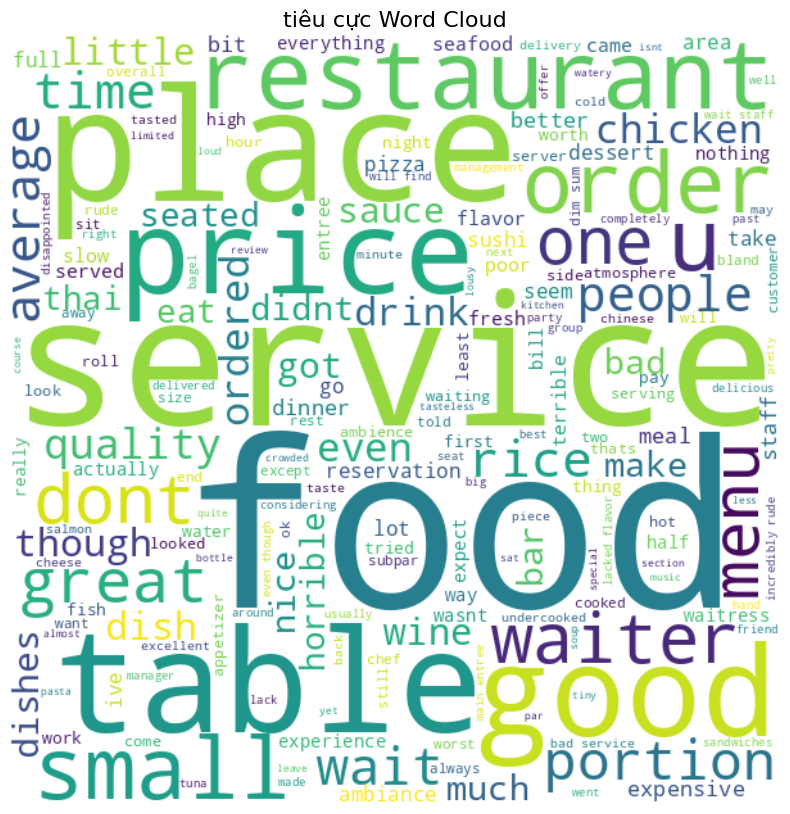

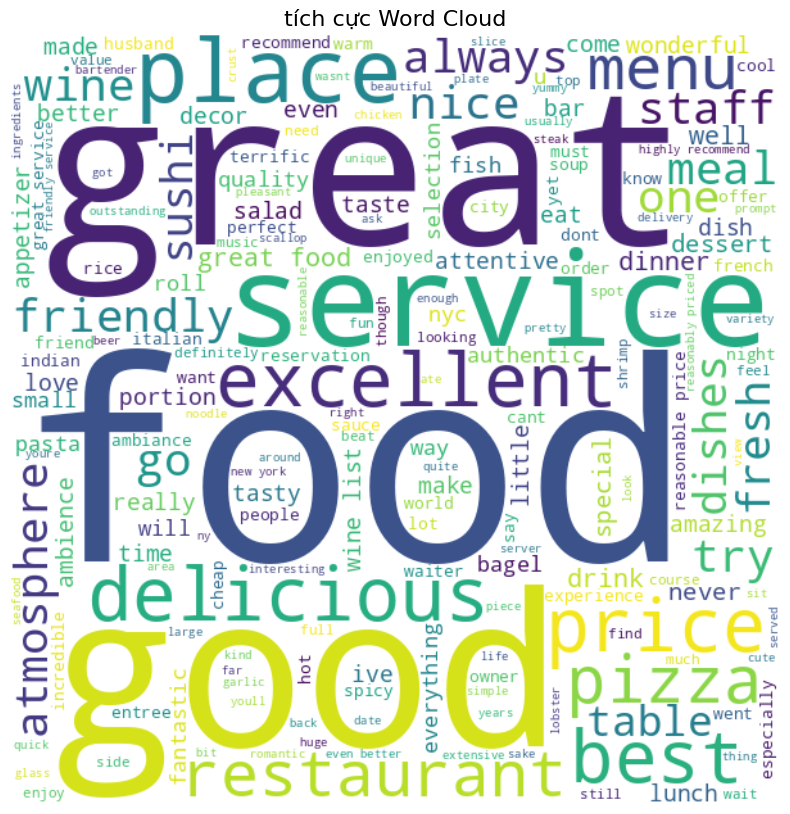

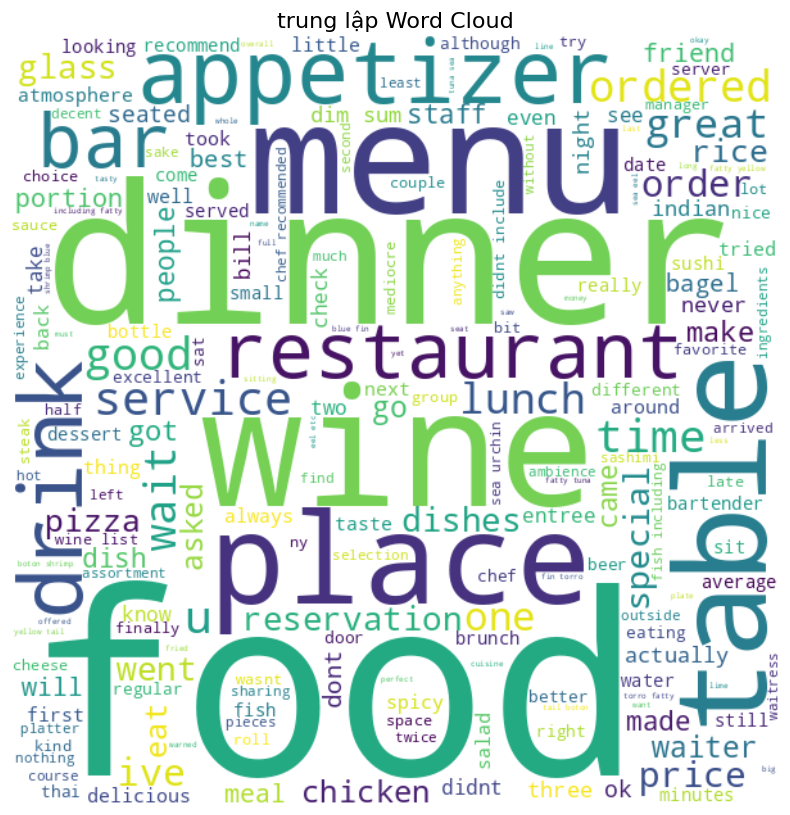

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Hàm tạo Word Cloud
def words_cloud(wordcloud, emotion):
    plt.figure(figsize=(10, 10))
    plt.title(emotion + ' Word Cloud', size=16)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Danh sách các cảm xúc
emotions_list = english_data['sentiment'].unique()

# Tạo Word Cloud cho từng cảm xúc
for emotion in emotions_list:
    # Lọc các câu có cảm xúc tương ứng và ghép chúng lại
    text = ' '.join(sentence for sentence in english_data.loc[english_data['sentiment'] == emotion, 'text'])

    # Khởi tạo và tạo Word Cloud
    wordcloud = WordCloud(width=600, height=600, background_color="white").generate(text)

    # Hiển thị Word Cloud cho cảm xúc hiện tại
    words_cloud(wordcloud, emotion)


In [ ]:
from collections import Counter
import pandas as pd
import random
import nltk
from nltk.corpus import wordnet

# Đảm bảo đã tải tài nguyên WordNet
nltk.download('wordnet')

# Dữ liệu đầu vào
texts = english_data['text']
labels = english_data['sentiment']

# Hàm tokenize đơn giản
def tokenize(text):
    return text.lower().split()  # Có thể thay bằng tokenizer nâng cao hơn nếu cần

# Gom các từ theo nhãn
words_by_label = {'tích cực': [], 'tiêu cực': [], 'trung lập': []}

# Kiểm tra sự hiện diện của các nhãn trong dữ liệu
for label in labels.unique():
    if label not in words_by_label:
        words_by_label[label] = []

for text, label in zip(texts, labels):
    if label in words_by_label:
        words_by_label[label].extend(tokenize(text))

# Tính tần suất từ trong từng nhãn
word_freq = {label: Counter(words) for label, words in words_by_label.items()}

# Tìm các từ xuất hiện ở mọi nhãn và lấy tần suất trung bình
all_words = set(word_freq['tích cực'].keys()) | set(word_freq['tiêu cực'].keys()) | set(word_freq['trung lập'].keys())

stop_words = []
threshold = 0.8  # Ngưỡng tần suất

for word in all_words:
    freq_in_labels = [word_freq[label].get(word, 0) for label in words_by_label]
    # Nếu từ xuất hiện ở mọi nhãn và có tần suất tương đối cao, coi là stop word
    if sum(1 for freq in freq_in_labels if freq > 0) == len(words_by_label):  # Xuất hiện ở tất cả nhãn
        avg_freq = sum(freq_in_labels) / len(freq_in_labels)
        if avg_freq > threshold * max(freq_in_labels):  # Kiểm tra ngưỡng tần suất
            stop_words.append(word)

# Ghi danh sách stop words ra file
with open('stop_words.txt', 'w') as f:
    f.write('\n'.join(stop_words))

print("Danh sách stop words được lưu tại: stop_words.txt")
print(f"Stop words (10 từ đầu): {stop_words[:10]}")

Danh sách stop words được lưu tại: stop_words.txt
Stop words (10 từ đầu): ['popcorn', 'people', '30.', 'itsuperb', 'variety,', 'nothing', 'halfprice', 'traffic', 'wrong.', 'lot']


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Hàm tìm từ đồng nghĩa cho từ tiếng Anh
def get_english_synonyms(word):
#trả về ghép các từ đó lại thành 1 câu và thêm vào câu mới
    synonyms = []
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.append(lemma.name())  # Lấy từ đồng nghĩa từ WordNet
    return set(synonyms)  # Trả về tập hợp để loại bỏ trùng lặp

# Hàm thay thế từ đồng nghĩa cho câu tiếng Anh
def synonym_replacement_english(sentence, n=1):
    words = sentence.split()
    new_sentence = words.copy()

    # Lọc các từ có từ đồng nghĩa
    random_word_list = list(set([word for word in words if len(get_english_synonyms(word)) > 0]))
    random.shuffle(random_word_list)

    num_replacements = min(n, len(random_word_list))  # Số lượng từ sẽ thay thế
    for random_word in random_word_list[:num_replacements]:
        synonyms = get_english_synonyms(random_word)
        if len(synonyms) > 0:
            synonym = random.choice(list(synonyms))  # Chọn từ đồng nghĩa ngẫu nhiên
            new_sentence = [synonym if word == random_word else word for word in new_sentence]

    return ' '.join(new_sentence)

In [ ]:
num_iterations = 2 # Số lần tạo câu tăng cường cho mỗi câu gốc

# Tạo danh sách để lưu trữ câu gốc, câu tăng cường và nhãn
original_sentences = []
enhanced_sentences = []
labels = []

# Thay thế từ đồng nghĩa cho từng câu trong english_data
for idx, row in english_data.iterrows():
    sentence = row['text']
    label = row['sentiment']

    # Thêm câu gốc và nhãn vào danh sách
    original_sentences.append(sentence)
    enhanced_sentences.append(sentence)  # Câu gốc cũng được lưu như một câu không thay đổi
    labels.append(label)

    # Tạo câu tăng cường
    for _ in range(num_iterations):
        enhanced_sentence = synonym_replacement_english(sentence, n=1)
        original_sentences.append(sentence)
        enhanced_sentences.append(enhanced_sentence)
        labels.append(label)

# Tạo DataFrame từ danh sách câu gốc, câu tăng cường và nhãn
df_enhanced = pd.DataFrame({
    'original_sentence': original_sentences,
    'enhanced_sentence': enhanced_sentences,
    'label': labels
})

# Tính tổng số câu gốc và câu tăng cường
total_original_sentences = len(original_sentences) // (num_iterations + 1)
total_enhanced_sentences = len(df_enhanced) - total_original_sentences

# Tính tổng số câu
total_sentences = total_original_sentences + total_enhanced_sentences
print(f"Tổng số câu gốc: {total_original_sentences}")
print(f"Tổng số câu tăng cường tiếng Anh: {total_enhanced_sentences}")
print(f"Tổng số câu (cả câu gốc và câu tăng cường): {total_sentences}")

# Hiển thị một vài cặp câu để kiểm tra nhãn
print("\nKiểm tra nhãn giữa câu gốc và câu tăng cường:")
for i in range(0, min(5, len(df_enhanced)), num_iterations + 1):  # Hiển thị tối đa 5 cặp câu
    original_sentence = df_enhanced['original_sentence'].iloc[i]
    original_label = df_enhanced['label'].iloc[i]

    print(f"\nCâu gốc: {original_sentence}")
    print(f"Nhãn của câu gốc: {original_label}")

    for j in range(1, num_iterations + 1):
        enhanced_sentence = df_enhanced['enhanced_sentence'].iloc[i + j]
        enhanced_label = df_enhanced['label'].iloc[i + j]

        print(f"Câu tăng cường {j}: {enhanced_sentence}")
        print(f"Nhãn của câu tăng cường {j}: {enhanced_label}")
        print(f"Kiểm tra nhãn khớp: {'Đúng' if original_label == enhanced_label else 'Sai'}")

Tổng số câu gốc: 3602
Tổng số câu tăng cường tiếng Anh: 7204
Tổng số câu (cả câu gốc và câu tăng cường): 10806

Kiểm tra nhãn giữa câu gốc và câu tăng cường:

Câu gốc: but the staff was so horrible to us.
Nhãn của câu gốc: tiêu cực
Câu tăng cường 1: but the stave was so horrible to us.
Nhãn của câu tăng cường 1: tiêu cực
Kiểm tra nhãn khớp: Đúng
Câu tăng cường 2: simply the staff was so horrible to us.
Nhãn của câu tăng cường 2: tiêu cực
Kiểm tra nhãn khớp: Đúng

Câu gốc: to be completely fair, the only redeeming factor was the food, which was above average, but couldnt make up for all the other deficiencies of teodora.
Nhãn của câu gốc: tích cực
Câu tăng cường 1: to be completely fair, the only redeeming factor equal the food, which equal above average, but couldnt make up for all the other deficiencies of teodora.
Nhãn của câu tăng cường 1: tích cực
Kiểm tra nhãn khớp: Đúng
Câu tăng cường 2: to be completely fair, the only redeeming factor embody the food, which embody above average,

In [ ]:
# Kết hợp cả câu gốc và câu tăng cường
df_en_combined = pd.DataFrame({
    'text': enhanced_sentences,  # Cột chứa cả câu gốc và câu tăng cường
    'sentiment': labels          # Cột nhãn tương ứng
})

# Hiển thị toàn bộ chiều dài cột
pd.set_option('display.max_colwidth', None)

# In ra một số câu mẫu để kiểm tra
print(df_en_combined.head(5))
print(f"Tổng số câu trong df_en_combined: {len(df_en_combined)}")


                                                                                                                                                         text  \
0                                                                                                                        but the staff was so horrible to us.   
1                                                                                                                        but the stave was so horrible to us.   
2                                                                                                                     simply the staff was so horrible to us.   
3      to be completely fair, the only redeeming factor was the food, which was above average, but couldnt make up for all the other deficiencies of teodora.   
4  to be completely fair, the only redeeming factor equal the food, which equal above average, but couldnt make up for all the other deficiencies of teodora.   

  sentiment  
0  tiêu cực  
1  ti

In [ ]:
# Đếm số lượng từng nhãn trong DataFrame
label_counts = df_en_combined['sentiment'].value_counts()

# In ra số lượng nhãn
print("\nSố lượng từng nhãn trong df_en_combined:")
for label, count in label_counts.items():
    print(f"{label}: {count}")



Số lượng từng nhãn trong df_en_combined:
tích cực: 6492
tiêu cực: 2415
trung lập: 1899


Phân bố nhãn cảm xúc:
sentiment
tích cực     6492
tiêu cực     2415
trung lập    1899
Name: count, dtype: int64


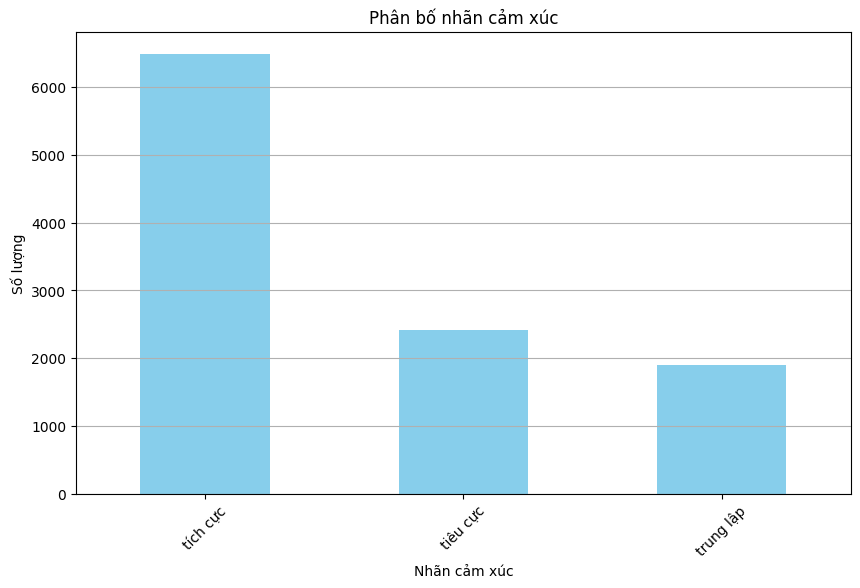

Tỷ lệ không cân bằng: 3.42
Dữ liệu không cân bằng.


In [ ]:
import matplotlib.pyplot as plt

# Lấy danh sách các câu và nhãn từ df_enhanced
sentences_list = df_enhanced['enhanced_sentence'].tolist()
labels_list = df_enhanced['label'].tolist()

# Tạo DataFrame từ danh sách câu và nhãn
data_df_en = pd.DataFrame({'text': sentences_list, 'sentiment': labels_list})

# Tính tần suất xuất hiện của từng nhãn cảm xúc
label_counts_en = data_df_en['sentiment'].value_counts()

# Hiển thị số lượng từng nhãn
print("Phân bố nhãn cảm xúc:")
print(label_counts_en)

# Vẽ biểu đồ phân bố nhãn cảm xúc
plt.figure(figsize=(10, 6))
label_counts_en.plot(kind='bar', color='skyblue')
plt.title('Phân bố nhãn cảm xúc')
plt.xlabel('Nhãn cảm xúc')
plt.ylabel('Số lượng')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Kiểm tra sự cân bằng
if label_counts_en.nunique() == 1:
    print("Dữ liệu không cân bằng.")
else:
    min_count = label_counts_en.min()
    max_count = label_counts_en.max()
    balance_ratio = max_count / min_count
    print(f"Tỷ lệ không cân bằng: {balance_ratio:.2f}")
    if balance_ratio <= 2:  # Nếu tỷ lệ không quá 2, có thể coi là cân bằng
        print("Dữ liệu tương đối cân bằng.")
    else:
        print("Dữ liệu không cân bằng.")


In [ ]:
import pandas as pd
from collections import Counter

# Bước 1: Lọc dữ liệu theo các nhãn cảm xúc
negative_data = df_en_combined[df_en_combined['sentiment'] == 'tiêu cực']
neutral_data = df_en_combined[df_en_combined['sentiment'] == 'trung lập']
positive_data = df_en_combined[df_en_combined['sentiment'] == 'tích cực']

# Bước 2: Xác định số lượng mẫu cần thêm
negative_count = len(negative_data)
neutral_count = len(neutral_data)
positive_count = len(positive_data)

# Tìm nhãn có số lượng ít nhất (có thể chọn nhãn khác nhau)
max_count = max(negative_count, neutral_count, positive_count)

# Tính số lượng mẫu cần thêm cho mỗi nhãn
needed_negative_samples = max_count - negative_count
needed_neutral_samples = max_count - neutral_count
needed_positive_samples = max_count - positive_count

# Bước 3: Thực hiện oversampling cho từng nhãn để cân bằng
oversampled_negative = negative_data.sample(n=needed_negative_samples, replace=True, random_state=42)
oversampled_neutral = neutral_data.sample(n=needed_neutral_samples, replace=True, random_state=42)
oversampled_positive = positive_data.sample(n=needed_positive_samples, replace=True, random_state=42)

# Bước 4: Kết hợp dữ liệu ban đầu với các câu đã oversampling
balanced_data_en = pd.concat([negative_data, neutral_data, positive_data, oversampled_negative, oversampled_neutral, oversampled_positive], ignore_index=True)

# Bước 5: Kiểm tra lại phân phối của các nhãn cảm xúc sau khi oversampling
balanced_label_counts = balanced_data_en['sentiment'].value_counts()
print("Số lượng nhãn sau khi oversampling:")
print(balanced_label_counts)


Số lượng nhãn sau khi oversampling:
sentiment
tiêu cực     6492
trung lập    6492
tích cực     6492
Name: count, dtype: int64


In [ ]:
# Cộng tổng số câu cho cả ba nhãn
total_sentences = balanced_data_en.shape[0]

print(f'Tổng số câu sau khi oversampling: {total_sentences}')


Tổng số câu sau khi oversampling: 19476


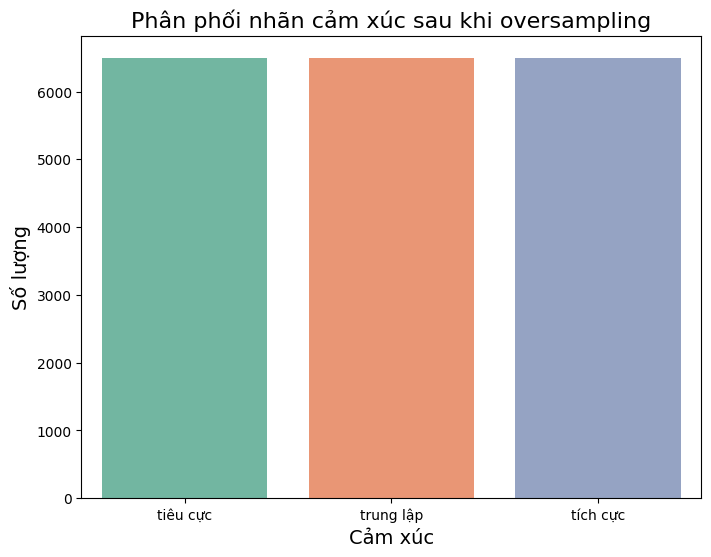

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Vẽ biểu đồ phân phối của các nhãn cảm xúc
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=balanced_data_en, hue='sentiment', palette='Set2', legend=False)

# Thêm tiêu đề và nhãn cho trục
plt.title("Phân phối nhãn cảm xúc sau khi oversampling", fontsize=16)
plt.xlabel("Cảm xúc", fontsize=14)
plt.ylabel("Số lượng", fontsize=14)

# Hiển thị biểu đồ
plt.show()


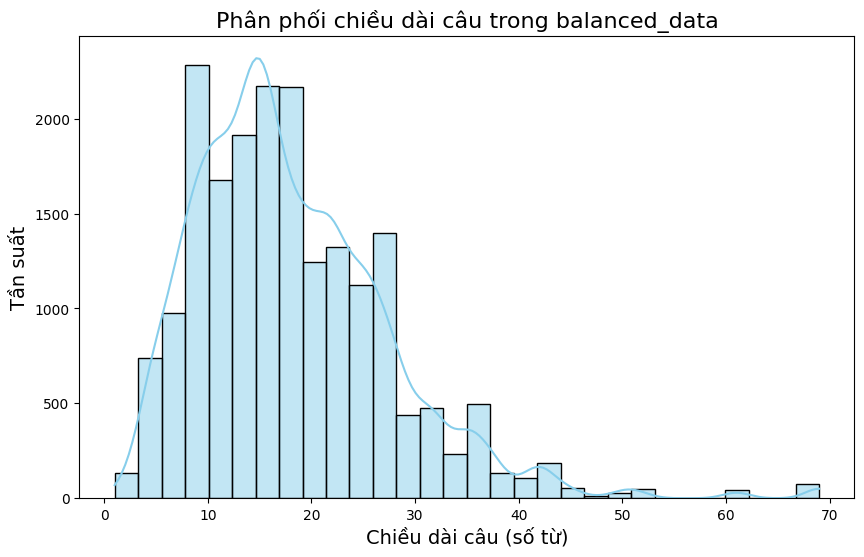

Maxlen (chiều dài câu lớn nhất): 69


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bước 1: Tính chiều dài của các câu trong balanced_data
sentence_lengths = balanced_data_en['text'].apply(lambda x: len(x.split()))  # Tính số từ trong mỗi câu

# Bước 2: Vẽ biểu đồ phân phối chiều dài câu
plt.figure(figsize=(10, 6))
sns.histplot(sentence_lengths, kde=True, color='skyblue', bins=30)
plt.title("Phân phối chiều dài câu trong balanced_data", fontsize=16)
plt.xlabel("Chiều dài câu (số từ)", fontsize=14)
plt.ylabel("Tần suất", fontsize=14)
plt.show()

# Bước 3: Tìm maxlen
maxlen = sentence_lengths.max()
print("Maxlen (chiều dài câu lớn nhất):", maxlen)


In [ ]:
import pandas as pd

# Nối hai DataFrame tiếng Anh và tiếng Việt lại với nhau
df_combined = pd.concat([balanced_data_en,balanced_data_vn], ignore_index=True)

# Kiểm tra kích thước và nội dung của DataFrame sau khi nối
print(f"Tổng số câu (sau khi nối dữ liệu tiếng Anh và tiếng Việt): {len(df_combined)}")
print(df_combined.head(5))


Tổng số câu (sau khi nối dữ liệu tiếng Anh và tiếng Việt): 91710
                                                                                                                                                                                                 text  \
0                                                                                                                                                                but the staff was so horrible to us.   
1                                                                                                                                                                but the stave was so horrible to us.   
2                                                                                                                                                             simply the staff was so horrible to us.   
3  they did not have mayonnaise, forgot our toast, left out ingredients ie cheese in an omelet, below hot temperatures and the baco

Phân bố nhãn cảm xúc sau khi gộp dữ liệu:
sentiment
tiêu cực     30570
trung lập    30570
tích cực     30570
Name: count, dtype: int64


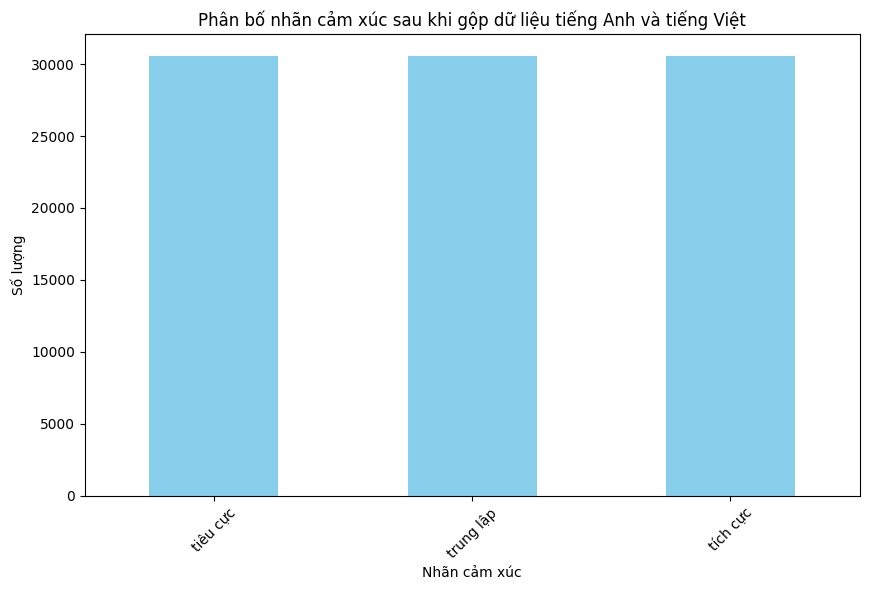

In [ ]:
# Tính phân bố nhãn cảm xúc sau khi gộp hai bộ dữ liệu
label_distribution = df_combined['sentiment'].value_counts()

# Hiển thị phân bố nhãn cảm xúc
print("Phân bố nhãn cảm xúc sau khi gộp dữ liệu:")
print(label_distribution)

# Vẽ biểu đồ để trực quan hóa phân bố nhãn cảm xúc
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
label_distribution.plot(kind='bar', color='skyblue')
plt.title("Phân bố nhãn cảm xúc sau khi gộp dữ liệu tiếng Anh và tiếng Việt")
plt.xlabel("Nhãn cảm xúc")
plt.ylabel("Số lượng")
plt.xticks(rotation=45)
plt.show()


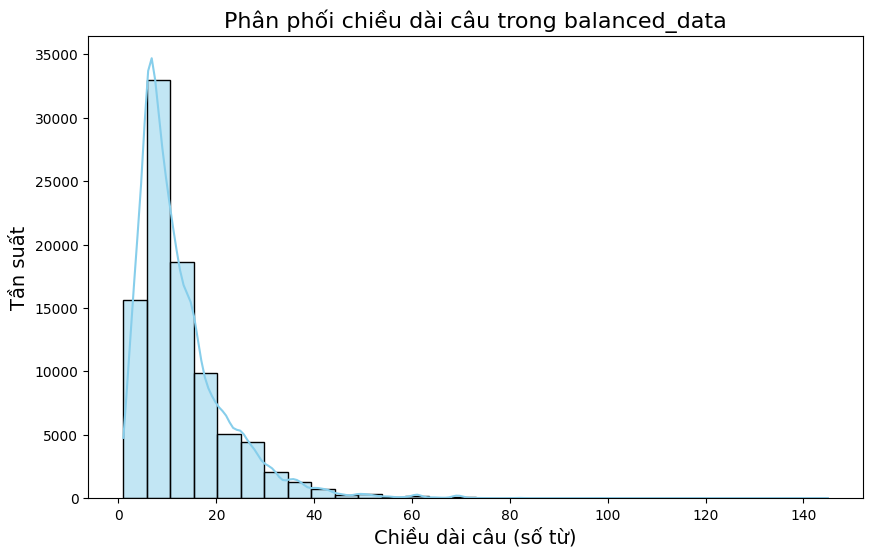

Maxlen (chiều dài câu lớn nhất): 145


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bước 1: Tính chiều dài của các câu trong balanced_data
sentence_lengths = df_combined['text'].apply(lambda x: len(x.split()))  # Tính số từ trong mỗi câu

# Bước 2: Vẽ biểu đồ phân phối chiều dài câu
plt.figure(figsize=(10, 6))
sns.histplot(sentence_lengths, kde=True, color='skyblue', bins=30)
plt.title("Phân phối chiều dài câu trong balanced_data", fontsize=16)
plt.xlabel("Chiều dài câu (số từ)", fontsize=14)
plt.ylabel("Tần suất", fontsize=14)
plt.show()

# Bước 3: Tìm maxlen
maxlen = sentence_lengths.max()
print("Maxlen (chiều dài câu lớn nhất):", maxlen)


In [ ]:
import pandas as pd
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf

label_dict = {'tiêu cực': 0, 'trung lập': 1, 'tích cực': 2}

# Lấy danh sách nhãn và câu từ DataFrame cân bằng
final_sentences = df_combined['text'].tolist()
final_labels = df_combined['sentiment'].tolist()

# Chuyển đổi nhãn sang định dạng số
label_idx = [label_dict[i] for i in final_labels]
label_tf = tf.keras.utils.to_categorical(label_idx, num_classes=len(label_dict)).astype('float32')

# Khởi tạo tokenizer
tokenizer_data = Tokenizer(oov_token='<00V>', filters='', split=' ')
tokenizer_data.fit_on_texts(final_sentences)

# Chuyển đổi văn bản thành chuỗi số
tokenized_data_text = tokenizer_data.texts_to_sequences(final_sentences)

# Padding cho dữ liệu
vec_data = pad_sequences(tokenized_data_text, padding='post', maxlen=50)
-
# Lưu tokenizer vào file
pickle.dump(tokenizer_data, open("tokenizer_data.pkl", "wb"))

# In ra kích thước của dữ liệu đầu vào sau khi padding
print("input data.shape ", vec_data.shape)  # In ra hình dạng dữ liệu đầu vào
data_vocab_size = len(tokenizer_data.word_index) + 1  # Tính kích thước từ vựng (số lượng từ duy nhất)
print("data_vocab_size:", data_vocab_size)  # In ra kích thước từ vựng

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_val, y_train, y_val = train_test_split(vec_data, label_tf, test_size=0.2, random_state=42)
print("validation sample: ", len(X_val))

# Chia tập huấn luyện thành tập kiểm tra và huấn luyện
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
print("training sample: ", len(X_train))
print("test sample: ", len(X_test))


input data.shape  (91710, 50)
data_vocab_size: 12024
validation sample:  18342
training sample:  66031
test sample:  7337


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, Bidirectional, LSTM, GRU, GlobalMaxPooling1D, LayerNormalization, Input, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam

def generate_model():
    dropout_threshold = 0.4
    input_dim = data_vocab_size
    output_dim = 32
    input_length = 50
    initializer = tf.keras.initializers.GlorotNormal()

    input_layer = Input(shape=(input_length,))
    feature = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length, embeddings_initializer="GlorotNormal")(input_layer)

    cnn_feature = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(feature)
    cnn_feature = MaxPooling1D()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)
    cnn_feature = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(cnn_feature)  # Fixed 'activations'
    cnn_feature = MaxPooling1D()(cnn_feature)
    cnn_feature = LayerNormalization()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)

    bi_lstm_feature = Bidirectional(LSTM(units=32, dropout=dropout_threshold, return_sequences=True, kernel_initializer=initializer), merge_mode='concat')(feature)
    bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)

    bi_lstm_feature = Bidirectional(GRU(units=32, dropout=dropout_threshold, return_sequences=True, kernel_initializer=initializer), merge_mode='concat')(bi_lstm_feature)
    bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)
    bi_lstm_feature = LayerNormalization()(bi_lstm_feature)

    combine_feature = tf.keras.layers.Concatenate()([cnn_feature, bi_lstm_feature])
    combine_feature = GlobalMaxPooling1D()(combine_feature)
    combine_feature = LayerNormalization()(combine_feature)

    classifier = Dense(90, activation='relu')(combine_feature)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(70, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(50, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(30, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(3, activation='softmax')(classifier)

    model = tf.keras.Model(inputs=input_layer, outputs=classifier)
    return model

# Instantiate and compile the model
model = generate_model()
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 50)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 50, 32)         │        384,768 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 50, 32)         │          3,104 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 25, 32)         │              0 │ conv1d[0][0]           │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 25, 32)         │              0 │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 50, 64)         │         16,640 │ embedding[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 25, 32)         │          3,104 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_2           │ (None, 25, 64)         │              0 │ bidirectional[0][0]    │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 12, 32)         │              0 │ conv1d_1[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 25, 64)         │         18,816 │ max_pooling1d_2[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 12, 32)         │             64 │ max_pooling1d_1[0][0]  │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_3           │ (None, 12, 64)         │              0 │ bidirectional_1[0][0]  │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 12, 32)         │              0 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 12, 64)         │            128 │ max_pooling1d_3[0][0]  │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 12, 96)         │              0 │ dropout_1[0][0],       │
│                           │                        │                │ layer_normalization_1… │
├──────────────────────

 Total params: 447,089 (1.71 MB)

 Trainable params: 447,089 (1.71 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callback_model = tf.keras.callbacks.ModelCheckpoint('model_cnn_bilstm.keras', monitor='val_loss', save_best_only=True)
history = model.fit(x = X_train, y = y_train, validation_data = (X_val, y_val), epochs = 15, batch_size = 128, callbacks =[callback_model])

Epoch 1/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 96s 161ms/step - accuracy: 0.5253 - loss: 0.9149 - val_accuracy: 0.8811 - val_loss: 0.3305
Epoch 2/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 138s 153ms/step - accuracy: 0.8901 - loss: 0.3368 - val_accuracy: 0.9191 - val_loss: 0.2449
Epoch 3/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 81s 157ms/step - accuracy: 0.9197 - loss: 0.2437 - val_accuracy: 0.9271 - val_loss: 0.2062
Epoch 4/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 85s 164ms/step - accuracy: 0.9323 - loss: 0.2045 - val_accuracy: 0.9339 - val_loss: 0.1890
Epoch 5/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 80s 156ms/step - accuracy: 0.9428 - loss: 0.1723 - val_accuracy: 0.9385 - val_loss: 0.1709
Epoch 6/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 80s 153ms/step - accuracy: 0.9472 - loss: 0.1615 - val_accuracy: 0.9407 - val_loss: 0.1716
Epoch 7/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 85s 158ms/step - accuracy: 0.9488 - loss: 0.1511 - val_accuracy: 0.9459 - val_loss: 0.1535
Epoch 8/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 84s 161ms/step - accuracy: 0.9543 - loss: 

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import numpy as np

# Giả sử y_true là nhãn thực tế và y_pred là dự đoán của mô hình
y_true = np.argmax(y_val, axis=-1)  # Nếu y_val là one-hot, chuyển thành lớp số

# Dự đoán của mô hình (model.predict trả về xác suất cho mỗi lớp)
y_pred_prob = model.predict(X_val)  # Dự đoán trên bộ validation

# Chuyển đổi xác suất thành các lớp dự đoán (các giá trị max từ xác suất)
y_pred = np.argmax(y_pred_prob, axis=-1)  # Chọn lớp có xác suất cao nhất

# Tính Precision, Recall, F1 score (average='weighted' để tính cho tất cả các lớp)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# In kết quả
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# In báo cáo phân loại chi tiết
print(classification_report(y_true, y_pred))


574/574 ━━━━━━━━━━━━━━━━━━━━ 30s 47ms/step
Precision: 0.9532
Recall: 0.9527
F1 Score: 0.9526
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      6201
           1       0.94      0.99      0.96      6001
           2       0.97      0.93      0.95      6140

    accuracy                           0.95     18342
   macro avg       0.95      0.95      0.95     18342
weighted avg       0.95      0.95      0.95     18342



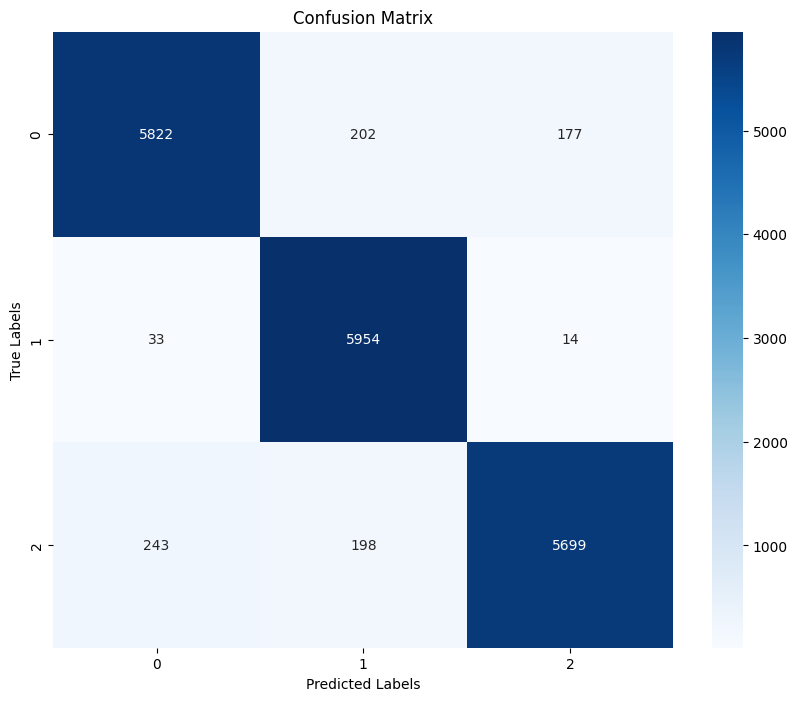

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Tính toán ma trận nhầm lẫn
conf_matrix = confusion_matrix(y_true, y_pred)

# Trực quan hóa ma trận nhầm lẫn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
model = tf.keras.models.load_model('model_cnn_bilstm.keras')


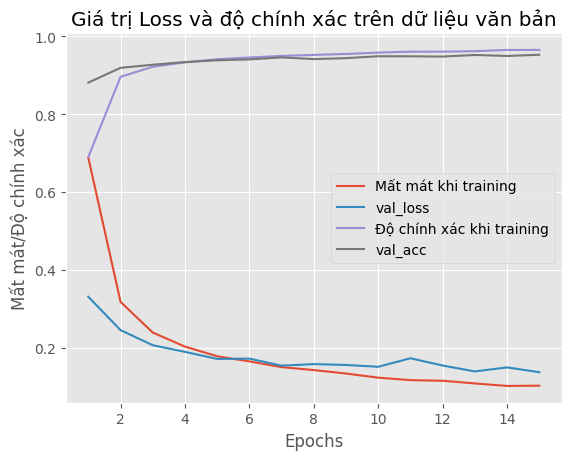

In [ ]:
# Plotting training & validation accuracy and loss values
plt.style.use("ggplot")
plt.figure()
epochs = range(1, len(history.history["loss"]) + 1)

plt.plot(epochs, history.history["loss"], label="Mất mát khi training")
plt.plot(epochs, history.history["val_loss"], label="val_loss")
plt.plot(epochs, history.history["accuracy"], label="Độ chính xác khi training")
plt.plot(epochs, history.history["val_accuracy"], label="val_acc")

plt.title("Giá trị Loss và độ chính xác trên dữ liệu văn bản")
plt.xlabel("Epochs")
plt.ylabel("Mất mát/Độ chính xác")
plt.legend()
plt.show()

In [ ]:
# Kiểm tra mô hình trên tập kiểm tra
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy:.4f}, Test loss: {test_loss:.4f}')

230/230 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9542 - loss: 0.1492
Test accuracy: 0.9504, Test loss: 0.1479
